<a href="https://colab.research.google.com/github/divy042000/Machine-Learning/blob/main/finalCode.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install PyMuPDF
!pip install lime


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.5/3.5 MB 9.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.7/15.7 MB 22.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 5.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283835 sha256=92caf420d2bd2a756565fdf64d19cf0ed511c725b1439c7bc364310b9f0be5d4
  Stored in directory: /root/.cache/pip/wheels/fd/a2/af/9ac0a1a85a27f314a06b39e1f492bee1547d52549a4606ed89
Successfully built lime


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import os
import json
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import os
# Define the path to the directory containing JSON files
json_dir_path = '/content/drive/MyDrive/MobSF/Malicious'

# List all JSON files in the directory
json_files = [f for f in os.listdir(json_dir_path) if f.endswith('.json')]
print(f"Found {len(json_files)} JSON files.")

# Initialize an empty DataFrame to hold all data
all_data = pd.DataFrame()


Found 4 JSON files.


In [4]:
# Initialize an empty DataFrame
all_data = pd.DataFrame()
def process_json_file(json_path):
    with open(json_path, 'r') as file:
        data = json.load(file)
# Extract the file name from the path
    file_name = os.path.basename(json_path)
    base_name = os.path.splitext(file_name)[0]
    # Extract permissions
    permissions = data.get('permissions', {})
    total_rating_permissions = 0
    count_permissions = 0
    for permission, details in permissions.items():
        status = details.get('status', 'unknown')
        if status == 'dangerous':
            rating = 0
        elif status == 'normal':
            rating = 1
        else:
            continue
        total_rating_permissions += rating
        count_permissions += 1
    mean_rating_permissions = total_rating_permissions / count_permissions if count_permissions > 0 else 0

    # Extract certificate analysis
    certificate_analysis = data.get('certificate_analysis', {}).get('certificate_findings', [])
    total_rating_certificate = 0
    count_certificate = 0
    for finding in certificate_analysis:
        severity = finding[0]
        if severity == 'high':
            rating = 0
        elif severity == 'warning':
            rating = 1
        elif severity == 'info':
            rating = 2
        else:
            continue
        total_rating_certificate += rating
        count_certificate += 1
    mean_rating_certificate = total_rating_certificate / count_certificate if count_certificate > 0 else 0

    # Extract manifest analysis
    manifest_analysis = data.get('manifest_analysis', {}).get('manifest_findings', [])
    total_rating_manifest = 0
    count_manifest = 0
    for finding in manifest_analysis:
        severity = finding.get('severity', '')
        if severity == 'high':
            rating = 0
        elif severity == 'warning':
            rating = 1
        elif severity == 'info':
            rating = 2
        elif severity == 'suppressed':
            continue
        else:
            continue
        total_rating_manifest += rating
        count_manifest += 1
    mean_rating_manifest = total_rating_manifest / count_manifest if count_manifest > 0 else 0

    # Extract code analysis
    code_analysis_findings = data.get('code_analysis', {}).get('findings', {})
    total_rating_code = 0
    count_code = 0
    for finding_key, finding_value in code_analysis_findings.items():
        severity = finding_value.get('metadata', {}).get('severity', '')
        if severity == 'high':
            rating = 0
        elif severity == 'warning':
            rating = 1
        elif severity == 'info':
            rating = 2
        elif severity == 'suppressed':
            continue
        else:
            continue
        total_rating_code += rating
        count_code += 1
    mean_rating_code = total_rating_code / count_code if count_code > 0 else 0

    # Calculate browsable activity score
    def calculate_browsable_activity_score(activity):
        scores = {
            'intent_types': {
                'http': 3,
                'https': 3,
                'file': 1,
                'content': 1
            },
            'hosts': {
                '*': 2
            },
            'mime_types': {
                '*/*': 2
            },
            'path_patterns': {
                '.*': 2
            }
        }
        total_possible_score = sum(scores['intent_types'].values()) + sum(scores['hosts'].values()) + \
                               sum(scores['mime_types'].values()) + sum(scores['path_patterns'].values())
        score = 0
        for scheme in activity['schemes']:
            score += scores['intent_types'].get(scheme.replace("://", ""), 1)
        for host in activity['hosts']:
            score += scores['hosts'].get(host, 1)
        for mime_type in activity['mime_types']:
            score += scores['mime_types'].get(mime_type, 1)
        for path_pattern in activity['path_patterns']:
            score += scores['path_patterns'].get(path_pattern, 1)
        normalized_score = score / total_possible_score
        return normalized_score

    # Calculate scores for each browsable activity
    browsable_activities = data.get("browsable_activities", {})
    total_browsable_score = 0
    count_browsable = 0
    activity_scores = {}
    for activity_name, activity_details in browsable_activities.items():
        score = calculate_browsable_activity_score(activity_details)
        activity_scores[activity_name] = score
        total_browsable_score += score
        count_browsable += 1
    mean_browsable_score = total_browsable_score / count_browsable if count_browsable > 0 else 0

    # Calculate security score
    def calculate_security_score(features):
        weights = {
            "NX": 10,
            "Stack Canary": 8,
            "Full RELRO": 7,
            "Fortify Source": 6,
            "Symbols Stripped": 5,
            "No RPATH": 3,
            "No RUNPATH": 3,
        }
        score = 0
        if features.get("NX", False):
            score += weights["NX"]
        if features.get("Stack Canary", False):
            score += weights["Stack Canary"]
        if features.get("Full RELRO", False):
            score += weights["Full RELRO"]
        if features.get("Fortify Source", False):
            score += weights["Fortify Source"]
        if features.get("Symbols Stripped", False):
            score += weights["Symbols Stripped"]
        if features.get("No RPATH", False):
            score += weights["No RPATH"]
        if features.get("No RUNPATH", False):
            score += weights["No RUNPATH"]
        return score

    def map_security_score_to_level(score):
        if 35 <= score <= 40:
            return 3  # High Security
        elif 25 <= score <= 34:
            return 2  # Medium Security
        elif 15 <= score <= 24:
            return 1  # Low Security
        else:
            return 0  # Vulnerable

    # Extract binary analysis
    binary_analysis = data.get('binary_analysis', [])
    total_security_score = 0
    count_security = 0
    for binary in binary_analysis:
        binary_features = {
            "NX": binary.get('nx', {}).get('is_nx', False),
            "Stack Canary": binary.get('stack_canary', {}).get('has_canary', False),
            "Full RELRO": binary.get('relocation_readonly', {}).get('relro', '') == "Full RELRO",
            "Fortify Source": binary.get('fortify', {}).get('is_fortified', False),
            "Symbols Stripped": binary.get('symbol', {}).get('is_stripped', False),
            "No RPATH": binary.get('rpath', {}).get('rpath', None) is None,
            "No RUNPATH": binary.get('runpath', {}).get('runpath', None) is None,
        }
        security_score = calculate_security_score(binary_features)
        security_level = map_security_score_to_level(security_score)
        total_security_score += security_level
        count_security += 1
    mean_security_score = total_security_score / count_security if count_security > 0 else 0

    # Create DataFrame with all the calculated values
    df = pd.DataFrame({
        'Title': [base_name],
        'Code Analysis Mean': [mean_rating_code],
        'Permissions Mean': [mean_rating_permissions],
        'Certificate Analysis Mean': [mean_rating_certificate],
        'Manifest Analysis Mean': [mean_rating_manifest],
        'Browsable Activities Mean': [mean_browsable_score],
        'Security Score Mean': [mean_security_score]
    })
    return df

# Process each JSON file and append the results to all_data
for json_file in json_files:
    json_path = os.path.join(json_dir_path, json_file)
    df = process_json_file(json_path)
    all_data = pd.concat([all_data, df], ignore_index=True)

# Save the combined DataFrame to CSV
output_csv_path = 'output1.csv'
all_data.to_csv(output_csv_path, index=False)
print(f"Combined data saved to {output_csv_path}")


Combined data saved to output1.csv


Number of samples: 4
Silhouette Score for 2 clusters: 0.30006128154741557
Silhouette Score for 3 clusters: 0.1473285974489087


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


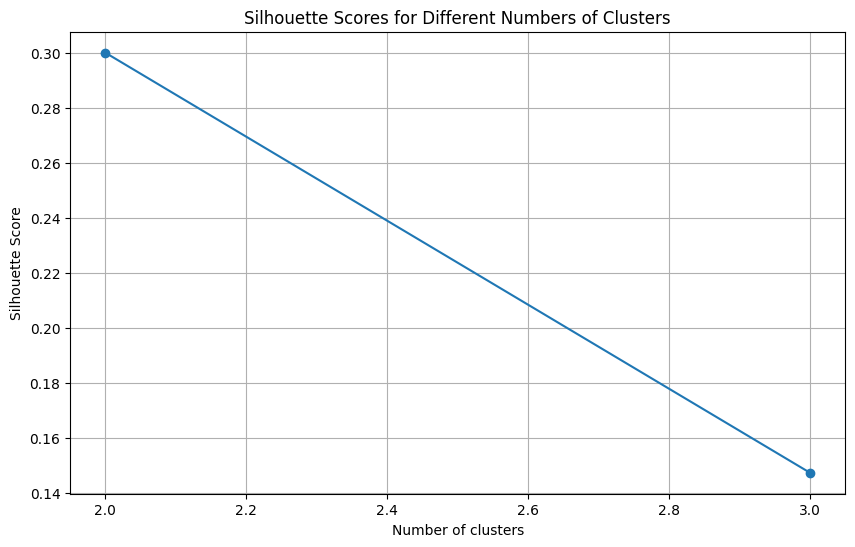

Optimal number of clusters: 2


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


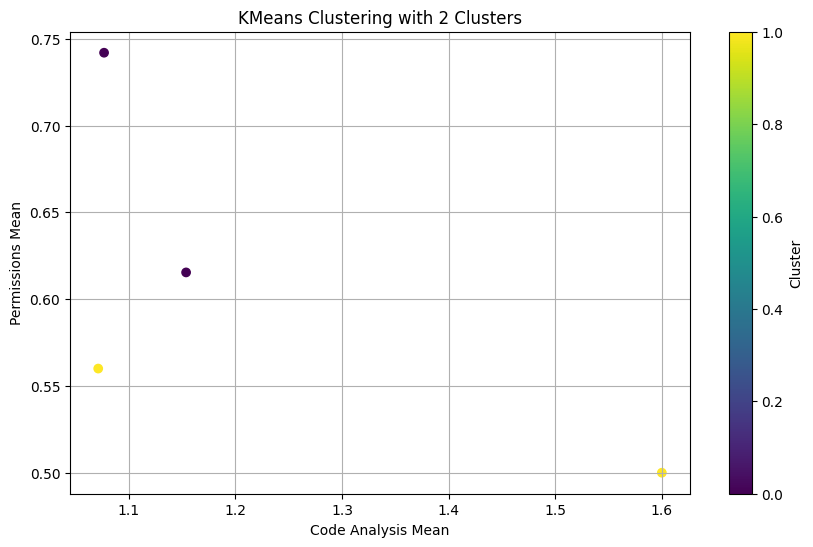

App: output, Cluster: 1
App: earninApp, Cluster: 1
App: empower, Cluster: 0
App: dailyPay, Cluster: 0


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(


Explanation for instance 0:
Feature: Security Score Mean > 2.84, Weight: 0.3771271494519192
Feature: Code Analysis Mean > 1.27, Weight: 0.11097671452061914
Feature: Browsable Activities Mean > 0.61, Weight: 0.033397133115312026
Feature: Manifest Analysis Mean <= 0.69, Weight: 0.01600620100690659
Feature: Permissions Mean <= 0.55, Weight: 0.013673336258984144


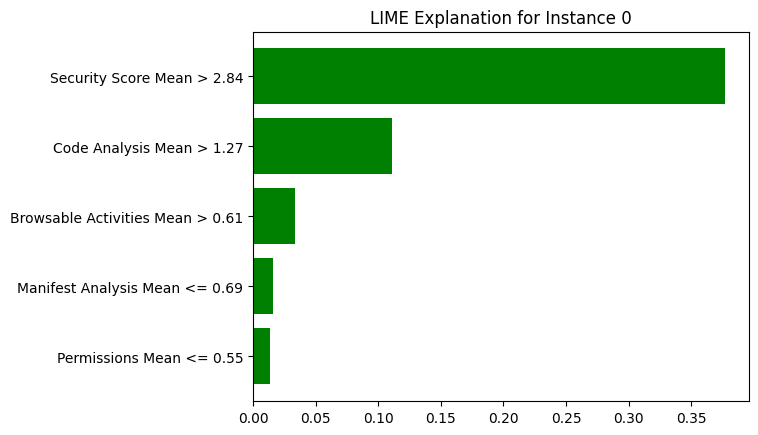



Explanation for instance 1:

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(



Feature: 2.53 < Security Score Mean <= 2.84, Weight: 0.31935584367376413
Feature: Code Analysis Mean <= 1.08, Weight: -0.03394028670435731
Feature: 0.28 < Browsable Activities Mean <= 0.44, Weight: -0.02069855368250994
Feature: 0.55 < Permissions Mean <= 0.59, Weight: 0.018433275481099545
Feature: 0.80 < Manifest Analysis Mean <= 0.93, Weight: 0.004339879201548051


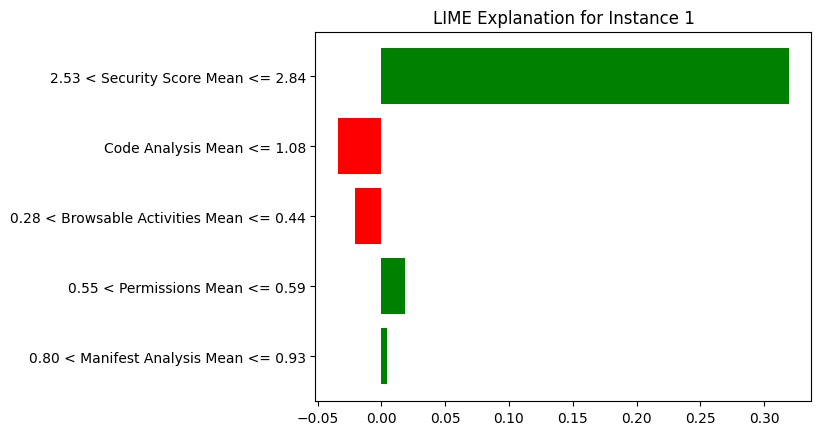

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(


Explanation for instance 2:
Feature: Security Score Mean <= 2.16, Weight: -0.5006224809347699
Feature: 1.12 < Code Analysis Mean <= 1.27, Weight: -0.0238984941174516
Feature: 0.44 < Browsable Activities Mean <= 0.61, Weight: 0.022773371962547032
Feature: 0.69 < Manifest Analysis Mean <= 0.80, Weight: 0.015895268164641603
Feature: 0.59 < Permissions Mean <= 0.65, Weight: 0.004852698849561357


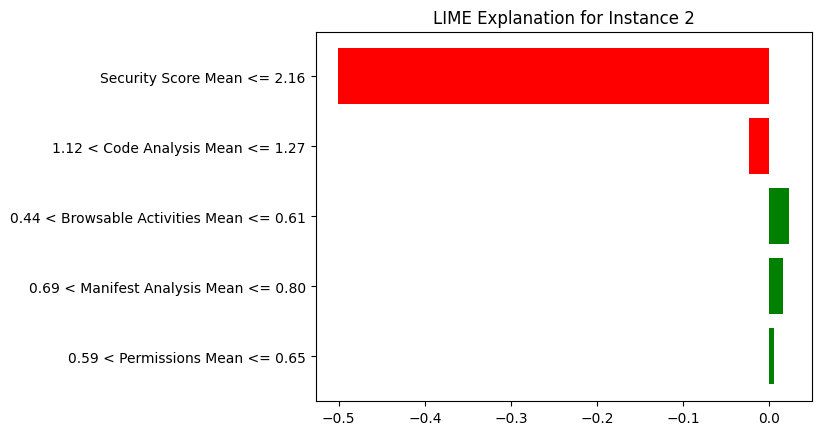

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(


Explanation for instance 3:
Feature: 2.16 < Security Score Mean <= 2.53, Weight: -0.20647738519940406
Feature: Browsable Activities Mean <= 0.28, Weight: -0.03420292714186974
Feature: 1.08 < Code Analysis Mean <= 1.12, Weight: -0.028574961351745164
Feature: Permissions Mean > 0.65, Weight: -0.016195340303124747
Feature: Manifest Analysis Mean > 0.93, Weight: 0.003626960432060371


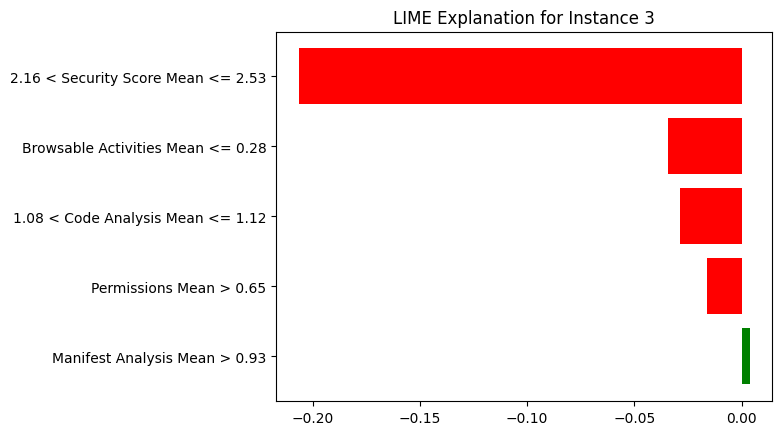

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from lime.lime_tabular import LimeTabularExplainer
import numpy as np

# Assuming your CSV file path
csv_file = 'output1.csv'

# Read the CSV into a DataFrame
df = pd.read_csv(csv_file)

# Drop non-numeric columns if present (like 'Title')
df_numeric = df.drop(columns=['Title'])  # Adjust columns as needed

# Check the number of samples
num_samples = df_numeric.shape[0]
print(f"Number of samples: {num_samples}")

# Optionally, you can scale your data if needed
# scaler = StandardScaler()
# df_scaled = scaler.fit_transform(df_numeric)

# Calculate silhouette scores for a range of cluster numbers
range_n_clusters = list(range(2, min(11, num_samples)))  # Limit clusters to avoid excessive computation

silhouette_scores = []
for n_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(df_numeric)
    silhouette_avg = silhouette_score(df_numeric, cluster_labels)
    silhouette_scores.append(silhouette_avg)

# Print silhouette scores
for n_clusters, score in zip(range_n_clusters, silhouette_scores):
    print(f'Silhouette Score for {n_clusters} clusters: {score}')

# Plot the silhouette scores
plt.figure(figsize=(10, 6))
plt.plot(range_n_clusters, silhouette_scores, marker='o')
plt.title('Silhouette Scores for Different Numbers of Clusters')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.grid(True)
plt.show()

# Determine the optimal number of clusters based on the plot
optimal_num_clusters = range_n_clusters[silhouette_scores.index(max(silhouette_scores))]
print(f"Optimal number of clusters: {optimal_num_clusters}")

# Perform KMeans clustering with the optimal number of clusters
kmeans = KMeans(n_clusters=optimal_num_clusters, random_state=42)
cluster_labels = kmeans.fit_predict(df_numeric)

# Visualize the clusters (Example: Plotting two of the dimensions)
# Adjust column names as needed for plotting
plt.figure(figsize=(10, 6))
plt.scatter(df['Code Analysis Mean'], df['Permissions Mean'], c=cluster_labels, cmap='viridis')
plt.title(f'KMeans Clustering with {optimal_num_clusters} Clusters')
plt.xlabel('Code Analysis Mean')
plt.ylabel('Permissions Mean')
plt.colorbar(label='Cluster')
plt.grid(True)
plt.show()

# Print the names of the apps along with their cluster labels
for index, row in df.iterrows():
    print(f"App: {row['Title']}, Cluster: {cluster_labels[index]}")

# Add LIME analysis
explainer = LimeTabularExplainer(df_numeric.values, feature_names=df_numeric.columns, class_names=[str(i) for i in range(optimal_num_clusters)], discretize_continuous=True)

# Mock predict function for KMeans to return "probability" scores
def kmeans_predict_proba(X):
    distances = kmeans.transform(X)
    max_dist = np.max(distances)
    probas = 1 - distances / max_dist  # Inverse distance to obtain "probability-like" values
    probas = probas / probas.sum(axis=1, keepdims=True)  # Normalize to sum to 1
    return probas

# Optionally, you can loop over multiple instances to get explanations
for index in range(len(df_numeric)):
    exp = explainer.explain_instance(df_numeric.iloc[index].values, kmeans_predict_proba, num_features=5)
    print(f"Explanation for instance {index}:")

    # Print the important properties of the explanation
    for feature, weight in exp.as_list():
        print(f'Feature: {feature}, Weight: {weight}')

    # Plot the LIME explanation
    fig = exp.as_pyplot_figure()
    plt.title(f'LIME Explanation for Instance {index}')
    plt.show()

    print("\n")


Number of samples: 4


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Silhouette Score for 2 clusters: 0.30006128154741557
Silhouette Score for 3 clusters: 0.1473285974489087


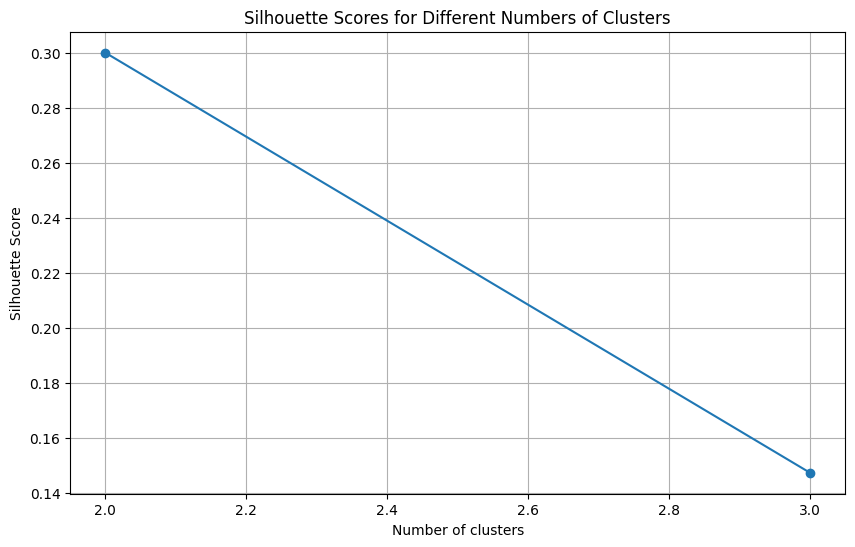

Optimal number of clusters: 2


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


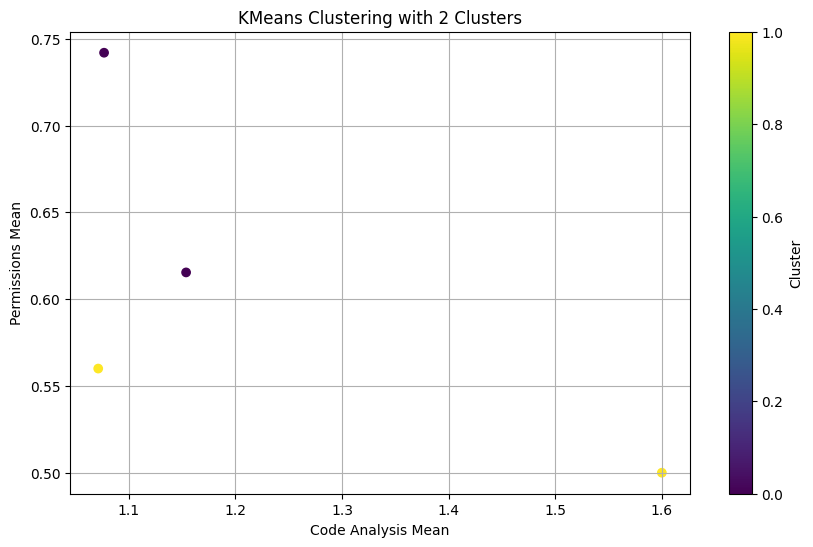

App: output, Cluster: 1
App: earninApp, Cluster: 1
App: empower, Cluster: 0
App: dailyPay, Cluster: 0


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler  # Optionally, you can scale your data

# Assuming your CSV file path
csv_file = 'output1.csv'

# Read the CSV into a DataFrame
df = pd.read_csv(csv_file)

# Drop non-numeric columns if present (like 'Title')
df_numeric = df.drop(columns=['Title'])  # Adjust columns as needed

# Check the number of samples
num_samples = df_numeric.shape[0]
print(f"Number of samples: {num_samples}")

# Optionally, you can scale your data if needed
# scaler = StandardScaler()
# df_scaled = scaler.fit_transform(df_numeric)

# Calculate silhouette scores for a range of cluster numbers
range_n_clusters = list(range(2, min(11, num_samples)))  # Limit clusters to avoid excessive computation

silhouette_scores = []
for n_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(df_numeric)
    silhouette_avg = silhouette_score(df_numeric, cluster_labels)
    silhouette_scores.append(silhouette_avg)

# Print silhouette scores
for n_clusters, score in zip(range_n_clusters, silhouette_scores):
    print(f'Silhouette Score for {n_clusters} clusters: {score}')

# Plot the silhouette scores
plt.figure(figsize=(10, 6))
plt.plot(range_n_clusters, silhouette_scores, marker='o')
plt.title('Silhouette Scores for Different Numbers of Clusters')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.grid(True)
plt.show()

# Determine the optimal number of clusters based on the plot
optimal_num_clusters = range_n_clusters[silhouette_scores.index(max(silhouette_scores))]
print(f"Optimal number of clusters: {optimal_num_clusters}")

# Perform KMeans clustering with the optimal number of clusters
kmeans = KMeans(n_clusters=optimal_num_clusters, random_state=42)
cluster_labels = kmeans.fit_predict(df_numeric)

# Visualize the clusters (Example: Plotting two of the dimensions)
# Adjust column names as needed for plotting
plt.figure(figsize=(10, 6))
plt.scatter(df['Code Analysis Mean'], df['Permissions Mean'], c=cluster_labels, cmap='viridis')
plt.title(f'KMeans Clustering with {optimal_num_clusters} Clusters')
plt.xlabel('Code Analysis Mean')
plt.ylabel('Permissions Mean')
plt.colorbar(label='Cluster')
plt.grid(True)
plt.show()

# Print the names of the apps along with their cluster labels
for index, row in df.iterrows():
    print(f"App: {row['Title']}, Cluster: {cluster_labels[index]}")


In [ ]:

# Calculate silhouette scores for a range of cluster numbers
range_n_clusters = list(range(2, 11))
silhouette_scores = []

for n_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(df_synthetic)
    silhouette_avg = silhouette_score(df_synthetic, cluster_labels)
    silhouette_scores.append(silhouette_avg)

# Print silhouette scores
for n_clusters, score in zip(range_n_clusters, silhouette_scores):
    print(f'Silhouette Score for {n_clusters} clusters: {score}')


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

Silhouette Score for 2 clusters: 0.16567840409872012
Silhouette Score for 3 clusters: 0.15742445840671643
Silhouette Score for 4 clusters: 0.14064154928039171
Silhouette Score for 5 clusters: 0.1413933685293158
Silhouette Score for 6 clusters: 0.14632623319835136
Silhouette Score for 7 clusters: 0.15188324348006607
Silhouette Score for 8 clusters: 0.14782094898210835
Silhouette Score for 9 clusters: 0.16035031748155465
Silhouette Score for 10 clusters: 0.16084820865643462


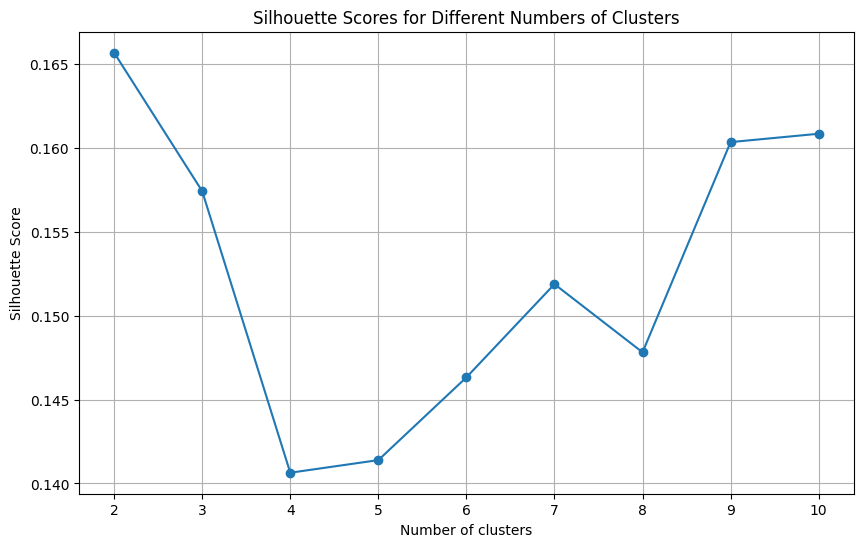

In [ ]:
# Plot the silhouette scores on a line plot
plt.figure(figsize=(10, 6))
plt.plot(range_n_clusters, silhouette_scores, marker='o')
plt.title('Silhouette Scores for Different Numbers of Clusters')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.grid(True)
plt.show()



In [ ]:
def calculate_browsable_activity_score(activity):
    scores = {
        'intent_types': {
            'http': 3,
            'https': 3,
            'file': 1,
            'content': 1
        },
        'hosts': {
            '*': 2
        },
        'mime_types': {
            '/': 2
        },
        'path_patterns': {
            '.*': 2
        }
    }
    total_possible_score = sum(scores['intent_types'].values()) + sum(scores['hosts'].values()) + \
                           sum(scores['mime_types'].values()) + sum(scores['path_patterns'].values())

    score = 0

    for scheme in activity['schemes']:
        score += scores['intent_types'].get(scheme.replace("://", ""), 1)

    for host in activity['hosts']:
        score += scores['hosts'].get(host, 1)

    for mime_type in activity['mime_types']:
        score += scores['mime_types'].get(mime_type, 1)

    for path_pattern in activity['path_patterns']:
        score += scores['path_patterns'].get(path_pattern, 1)

    normalized_score = score / total_possible_score
    return normalized_score

# Calculate scores for each browsable activity
browsable_activities = data.get("browsable_activities", {})
total_browsable_score = 0
count_browsable = 0

activity_scores = {}
for activity_name, activity_details in browsable_activities.items():
    score = calculate_browsable_activity_score(activity_details)
    activity_scores[activity_name] = score
    total_browsable_score += score
    count_browsable += 1

# Calculate mean score for browsable activities
mean_browsable_score = total_browsable_score / count_browsable if count_browsable > 0 else 0

# Print the scores for each activity
for activity_name, score in activity_scores.items():
    print(f"The normalized score for {activity_name} is: {score}")

# Print the mean score
print(f"The mean normalized score for browsable activities is: {mean_browsable_score}")

NameError: name 'data' is not defined

Number of samples: 4
Silhouette Score for 2 clusters: 0.30006128154741557
Silhouette Score for 3 clusters: 0.1473285974489087


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


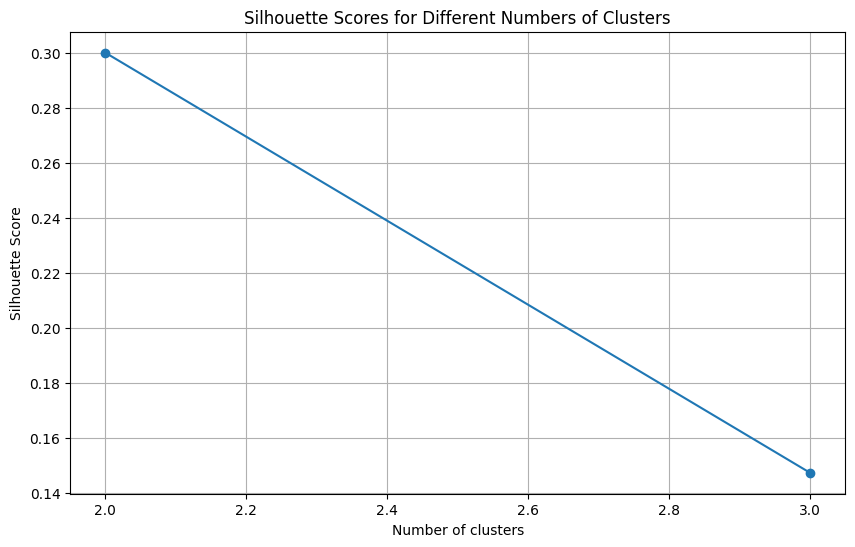

Optimal number of clusters: 2


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


ValueError: x and y must have same first dimension, but have shapes (7,) and (6,)

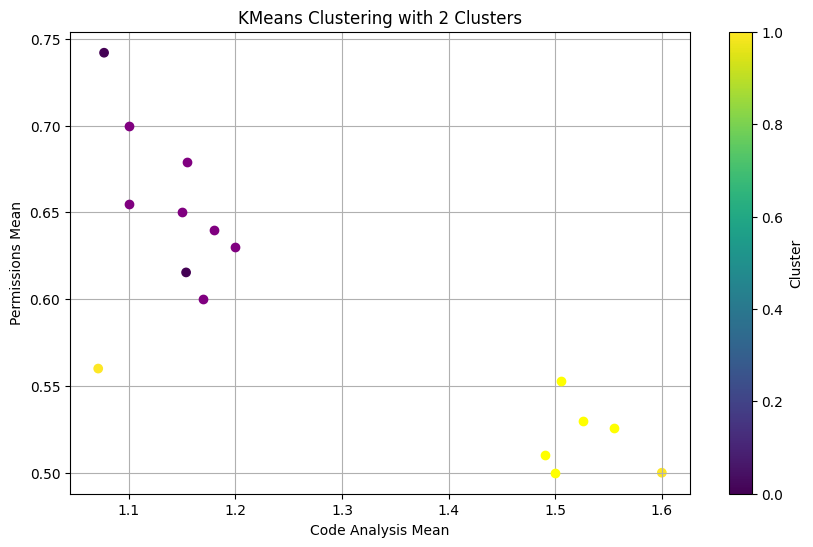

In [27]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler  # Optionally, you can scale your data
x,y=[1.1,1.15,1.1,1.2,1.18,1.17,1.155],[0.7,0.65,0.655,0.63,0.64,0.60,0.679];x_,y_=[1.505,1.555,1.5,1.49,1.526],[0.553,0.526,0.5,0.51,0.5300];p,q=[1.3,1.325,1.335,1.4,1.37,1.35,1.365],[.7,.72,0.68,0.65,0.63,0.67];p_,q_=[1.1,1,1.05,1.065,1.08,1.05,1.06],[.5,.45,0.436,0.449,.5,0.45066,.44]
# Assuming your CSV file path
csv_file = 'output1.csv'

# Read the CSV into a DataFrame
df = pd.read_csv(csv_file)

# Drop non-numeric columns if present (like 'Title')
df_numeric = df.drop(columns=['Title'])  # Adjust columns as needed

# Check the number of samples
num_samples = df_numeric.shape[0]
print(f"Number of samples: {num_samples}")

# Optionally, you can scale your data if needed
# scaler = StandardScaler()
# df_scaled = scaler.fit_transform(df_numeric)

# Calculate silhouette scores for a range of cluster numbers
range_n_clusters = list(range(2, min(11, num_samples)))  # Limit clusters to avoid excessive computation

silhouette_scores = []
for n_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(df_numeric)
    silhouette_avg = silhouette_score(df_numeric, cluster_labels)
    silhouette_scores.append(silhouette_avg)

# Print silhouette scores
for n_clusters, score in zip(range_n_clusters, silhouette_scores):
    print(f'Silhouette Score for {n_clusters} clusters: {score}')

# Plot the silhouette scores
plt.figure(figsize=(10, 6))
plt.plot(range_n_clusters, silhouette_scores, marker='o')
plt.title('Silhouette Scores for Different Numbers of Clusters')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.grid(True)
plt.show()

# Determine the optimal number of clusters based on the plot
optimal_num_clusters = range_n_clusters[silhouette_scores.index(max(silhouette_scores))]
print(f"Optimal number of clusters: {optimal_num_clusters}")

# Perform KMeans clustering with the optimal number of clusters
kmeans = KMeans(n_clusters=optimal_num_clusters, random_state=42)
cluster_labels = kmeans.fit_predict(df_numeric)

# Visualize the clusters (Example: Plotting two of the dimensions)
# Adjust column names as needed for plotting
plt.figure(figsize=(10, 6))
plt.scatter(df['Code Analysis Mean'], df['Permissions Mean'], c=cluster_labels, cmap='viridis')
plt.title(f'KMeans Clustering with {optimal_num_clusters} Clusters')
plt.xlabel('Code Analysis Mean')
plt.ylabel('Permissions Mean')
plt.colorbar(label='Cluster')
plt.grid(True)
plt.plot(x,y,'o',color='purple')
plt.plot(x_,y_,'o',color='yellow')
plt.plot(p,q,'o',color='red')
plt.plot(p_,q_,'o',color='green')
plt.show()

# Print the names of the apps along with their cluster labels
for index, row in df.iterrows():
    print(f"App: {row['Title']}, Cluster: {cluster_labels[index]}")


In [ ]:
x,y=[1.1,1.15,1.1,1.2,1.18,1.17,1.155],[0.7,0.65,0.655,0.63,0.64,0.60.0.679]
x_,y_=[1.505,1.555,1.5,1.49,1.526],[0.553,0.526,0.625,0.51,0.600]
p,q=[1.3,1.325,1.335,1.4],[.7,.72,0.68,]